In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import  torch
import time
#TODO: remove
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(123)

In [2]:
def polynomial_fun(w, x):
    x = x.view(-1, 1)
    powers_of_x = x**torch.arange(len(w)).view(1, -1)
    y = torch.mm(powers_of_x, w)

    return y.squeeze()

In [3]:

#implement task script 1

#1) Use polynomial_fun (𝑀 = 2, 𝐰 = [1,2,3]T) to generate a training set and a test set
w = torch.tensor([1, 2, 3], dtype=torch.float32).unsqueeze(1)
x_train = torch.linspace(-20, 20, 20)
x_test = torch.linspace(-20, 20, 10)
y_train = polynomial_fun(w, x_train)
y_test = polynomial_fun(w, x_test)
#observed t values with gauss noise 
t_train = y_train + 0.5 * torch.randn_like(y_train)
t_test = y_test + 0.5 * torch.randn_like(y_test)
M = torch.tensor([2,3,4])

In [4]:


def fit_polynomial_ls(x, t, M):
    x = x.view(-1, 1)
    t = t.view(-1, 1)

    powers_of_x = x**torch.arange(M+1, dtype=torch.float32)

    w = torch.linalg.lstsq(powers_of_x, t).solution

    return w.view(-1)

def fit_polynomial_sgd(x, t, M = 0, lr=1e-2, miniBatchSize=5, print_freq=100, N_epochs=2000):
    #initialise weights to 1
    torch.manual_seed(123)

    x = x.view(-1, 1)
    t = t.view(-1, 1)
    pow_of_x = x**torch.arange(M + 1).view(1, -1)
    weights = torch.rand(M + 1, 1, requires_grad=True)

    #print('weights ', model.weight.data)
    #change to sgd
    opt = torch.optim.Adam([weights], lr = lr)
    dataset = TensorDataset(pow_of_x, t)
    loader = DataLoader(dataset, batch_size=miniBatchSize, shuffle=True)
    mse_loss =  torch.nn.MSELoss()
    total_loss = 0.0
    num_batches = 0
    min_loss = torch.inf
    loss_diff_threshold = 1e-3
    losses = []
    grad_norms = []
    print('Training with SGD , polynomial degree ', M)
    
    for epoch in range(N_epochs):
        for batch_x, batch_t in loader:
            #normalize batch x
            #batch_x = (batch_x - batch_x.mean())/batch_x.std()
            #check if this is supposed to be after step
            opt.zero_grad()
            #used wights multiplication wirg batch x to do the prediction
            batch_y = batch_x@weights
            #print('output',  batch_y)
            #mean square loss
            loss = mse_loss(batch_y, batch_t)
            loss.backward() 
            #TODO: for plotting only
            grad_norms.append(weights.grad.norm().item())

            #torch.nn.utils.clip_grad_value_(weights, 1)
            total_loss += loss.item()
            num_batches += 1
            opt.step()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        
        #doesn't d much 
        if abs(min_loss - loss.item()) < loss_diff_threshold:
            print('Early stopping at epoch {} with loss {}'.format(epoch+1, avg_loss))
            break;
        min_loss = avg_loss
        
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, avg_loss))
        total_loss = 0.0
        num_batches = 0
        
    #Plotting
    #TODO:remove

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(grad_norms)
    plt.title('Gradient norm per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.show()
                
    return weights.detach()


Training RMSE between the observed training data and the underlying “true” polynomial curve is  0.5441733002662659
Test RMSE between the observed training data and the underlying “true” polynomial curve in training data is  0.38011598587036133
Test Mean difference between the observed training data and the underlying “true” polynomial curve in training data is  -0.07385587692260742 and standard diviation is 0.3930415213108063
Training Mean difference between the observed training data and the underlying “true” polynomial curve is  -0.1139843612909317 and standard diviation is 0.5459247827529907
For polynomial degree  2
elapsed time for fit_polynomial_ls: 0.02 seconds
Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is 0.000, and standard diviation: 0.502
Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is -0.036, and standard diviation: 0.464
Training RMSE between the LS values and the underl

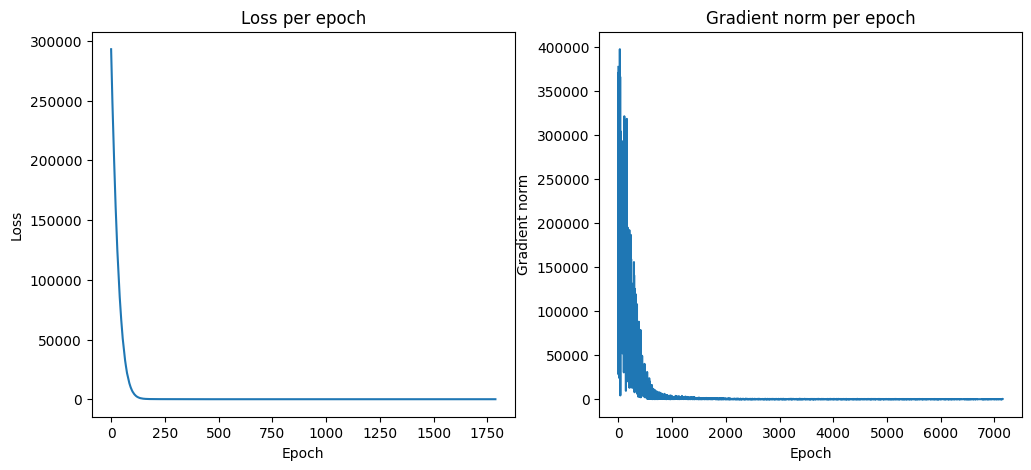

elapsed time for fit_polynomial_sgd: 6.78 seconds
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.223, and standard deviation is 0.143
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.223, and standard deviation is 0.143
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.543, and standard deviation is 0.537
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.481, and standard deviation is 0.537
RMSE between the true weights and predicted by SGD weights is 0.117
For polynomial degree  3
elapsed time for fit_polynomial_ls: 0.00 seconds
Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is 0.000, and standard diviation: 0.417
Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is -0.

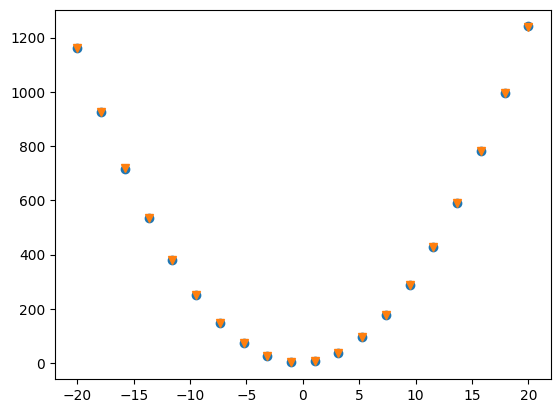

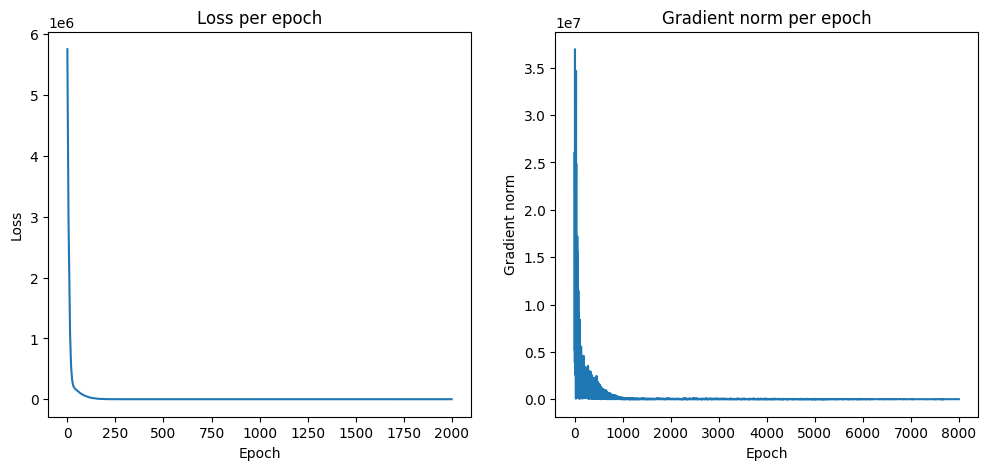

elapsed time for fit_polynomial_sgd: 5.78 seconds
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.536, and standard deviation is 0.262
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.536, and standard deviation is 0.262
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.581, and standard deviation is 0.549
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 0.646, and standard deviation is 0.549
RMSE between the true weights and predicted by SGD weights is 2.009
For polynomial degree  4
elapsed time for fit_polynomial_ls: 0.00 seconds
Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is 0.000, and standard diviation: 0.401
Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is -0.

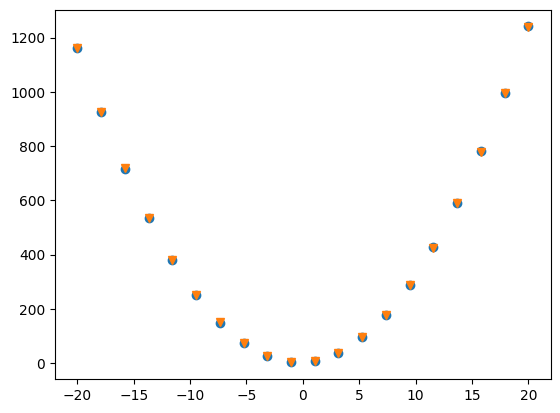

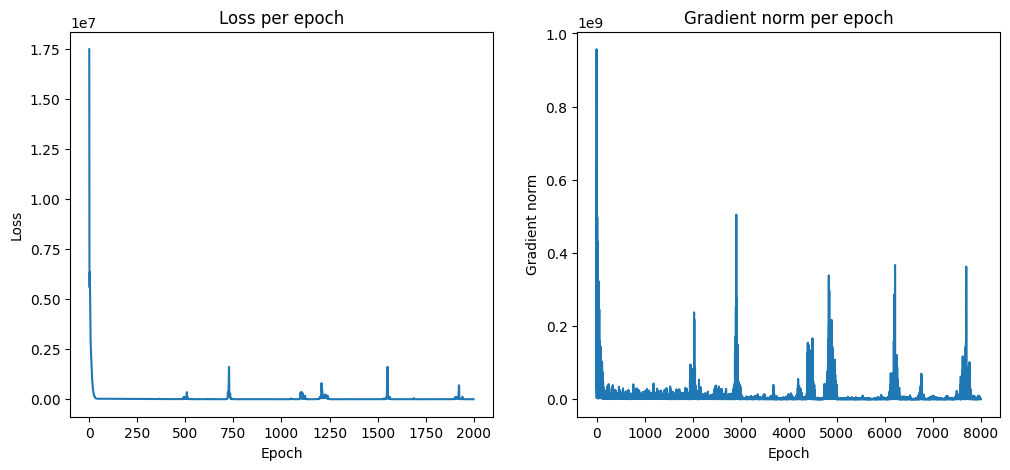

elapsed time for fit_polynomial_sgd: 5.95 seconds
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 6.745, and standard deviation is 3.982
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 6.745, and standard deviation is 3.982
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 7.635, and standard deviation is 7.561
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 7.999, and standard deviation is 7.561
RMSE between the true weights and predicted by SGD weights is 4.273


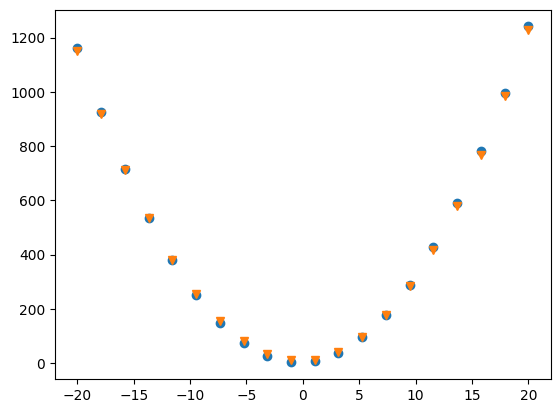

In [5]:

# diff in noisy and not noisy data 
diff_obs_train = t_train - y_train
diff_obs_test = t_test - y_test
#mean diff
sd_obs_train, mean_obs_train = torch.std_mean(diff_obs_train)
sd_obs_test, mean_obs_test = torch.std_mean(diff_obs_test)
#rmse
rmse_obs_train = torch.sqrt(torch.mean(torch.square(diff_obs_train)))
rmse_obs_test = torch.sqrt(torch.mean(torch.square(diff_obs_test)))
print('Training RMSE between the observed training data and the underlying “true” polynomial curve is ', rmse_obs_train.item())
print('Test RMSE between the observed training data and the underlying “true” polynomial curve in training data is ', rmse_obs_test.item())
print('Test Mean difference between the observed training data and the underlying “true” polynomial curve in training data is ', mean_obs_test.item(), 'and standard diviation is', sd_obs_test.item())
print('Training Mean difference between the observed training data and the underlying “true” polynomial curve is ', mean_obs_train.item(), 'and standard diviation is', sd_obs_train.item() )



for i, m in enumerate(M):
    if len(w) < m.item() + 1:
        w = torch.cat((w, w[-1].unsqueeze(0) + 1))
    #fitting LS
    print('For polynomial degree ', m.item())
    t0 = time.time()
    w_hat = fit_polynomial_ls(x_train, t_train, m.item()).unsqueeze(1)
    t1 = time.time()
    print("elapsed time for fit_polynomial_ls: %.2f seconds" % (t1-t0))

    pred_train = polynomial_fun(w_hat, x_train).squeeze()
    pred_test = polynomial_fun(w_hat, x_test).squeeze()
    
    #rmse
    diff_pred_train = pred_train - t_train
    diff_pred_test = pred_test - t_test
    diff_pred_weights = w.view(-1, 1) - w_hat
    
    rmse_train = torch.sqrt(torch.mean(torch.square(diff_pred_train)))
    rmse_test = torch.sqrt(torch.mean(torch.square(diff_pred_test)))
    rmse_weights = torch.sqrt(torch.mean(torch.square(diff_pred_weights)))
    std_dev_train = torch.std(diff_pred_train)
    std_dev_test = torch.std(diff_pred_test)
    
    #mean diff
    sd_pred_train, mean_pred_train = torch.std_mean(diff_pred_train)
    sd_pred_test, mean_pred_test = torch.std_mean(diff_pred_test)

    print('Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_train.item(), sd_pred_train.item()) )
    print('Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_test.item(), sd_pred_test.item()) )
    print('Training RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_train.item(), std_dev_train.item()))
    print('Test RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_test.item(), std_dev_test.item()))
    print('RMSE between the true weights and predicted by LS weights is {:.3f}'.format( rmse_weights.item()))

    #for SGD
    t0 = time.time()
    w_hat_opimized = fit_polynomial_sgd(x_train, t_train, m.item())
    t1 = time.time()
    print("elapsed time for fit_polynomial_sgd: %.2f seconds" % (t1-t0))
    #training
    pred_train_opt = polynomial_fun(w_hat_opimized, x_train).squeeze()
    
    #test
    pred_test_opt = polynomial_fun(w_hat_opimized, x_test).squeeze()
    
    #mean difference 
    std_difference_tr, mean_difference_tr = torch.std_mean(torch.abs(pred_train_opt - y_train))
    std_difference_te, mean_difference_te = torch.std_mean(torch.abs(pred_train_opt - y_train))
    print('Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_tr.item(), std_difference_tr.item()))
    print('Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_te.item(), std_difference_te.item()))
    
    #rmse
    diff_pred_train_opt = pred_train_opt - t_train
    diff_pred_test_opt = pred_test_opt - t_test
    diff_pred_weights_opt = w.view(-1, 1) - w_hat_opimized
    rmse_train_opt= torch.sqrt(torch.mean(torch.square(diff_pred_train_opt)))
    rmse_test_opt= torch.sqrt(torch.mean(torch.square(diff_pred_test_opt)))
    rmse_weights_opt = torch.sqrt(torch.mean(torch.square(diff_pred_weights_opt)))
    std_dev_train_opt = torch.std(diff_pred_train_opt)
    std_dev_test_opt = torch.std(diff_pred_train_opt)
    print('Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_train_opt.item(), std_dev_train_opt.item()))
    print('Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_test_opt.item(), std_dev_test_opt.item()))
    print('RMSE between the true weights and predicted by SGD weights is {:.3f}'.format( rmse_weights_opt.item()))
    
        #TODO: remove all plots
    fig, ax = plt.subplots()
    ax.plot(x_train, y_train, 'o')
    ax.plot(x_train, pred_train_opt, 'v')
